In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   #if like me you do not have a lot of memory in your GPU
os.environ["CUDA_VISIBLE_DEVICES"] = "" #then these two lines force keras to use your CPU
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import h5py

import matplotlib as mpl
COLOR = 'white'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
from tqdm.auto import tqdm

In [ ]:
def read_data(path_dataset):
    data = {}
    time_init =     "Time:  0.00000E+00 y"
    time_final =    "Time:  5.00000E+00 y"

    for file in tqdm(list(os.listdir(path_dataset))):
        try:
            path_data = os.path.join(path_dataset,file)
            print(file)
            if not os.path.isdir(path_data):
                continue
            filename = os.path.join(path_data,"pflotran.h5") 
            with h5py.File(filename, "r") as f:
                for key, value in f[time_final].items():
                    if not key in data: # and not key=='Material_ID':
                        data[key] = []
                    #if not key=='Material_ID':
                    if key=='Liquid_Pressure [Pa]':
                        data[key].append(np.array(f[time_init]["Liquid_Pressure [Pa]"]))
                    else:
                        data[key].append(np.array(value))

        except Exception as e:
            tqdm.write(f"lololololololoo: {e}")


    #n_data_points = 0
    #temp_list = []
    #key_list = []
    for key,value in data.items():
        data[key] = np.array(value)
        #key_list.append(key)
        #n_data_points = data[key].shape[0]
        #temp_list.append(data[key])

    #print(key_list)
    return data

In [105]:
def aligned_colorbar(*args,**kwargs):
    cax = make_axes_locatable(plt.gca()).append_axes("right",size= 0.3,pad= 0.05)
    plt.colorbar(*args,cax=cax,**kwargs)
    
def plot_sample(data, sample_id, view="top"):
    n_dims = len(data)
    fig, axes = plt.subplots(n_dims,1,sharex=True,figsize=(20,3*n_dims))
    plt.figure(figsize= (20,3*n_dims))
    for i,(key,value) in zip(range(n_dims),data.items()):
        plt.sca(axes[i])
        field = value[sample_id]
        if len(field.shape) != 3:
            # no 3D data
            continue
        index = key.find(' [')
        title = key
        if index != -1:
            title = key[:index]
        plt.title(title)
        if view=="top":
            plt.imshow(field[:,:,15])
            plt.xlabel("y")
            plt.ylabel("x")
        elif view=="side":
            plt.imshow(field[10,:,::-1].T)
            plt.xlabel("y")
            plt.ylabel("z")
        elif view=="side_hp":
            plt.imshow(field[9,:,::-1].T)
            plt.xlabel("y")
            plt.ylabel("z")
        elif view=="top_hp":
            plt.imshow(field[:,:,9])
            plt.xlabel("y")
            plt.ylabel("x")
        aligned_colorbar(label=key)
    plt.show()

In [108]:
path_dir = "/home/pelzerja/Development/simulation_groundtruth_pflotran/Phd_simulation_groundtruth/approach2_dataset_generation_simplified"
dataset_name = "dataset_HDF5"
path_dataset = os.path.join(path_dir, dataset_name)

data = read_data(path_dataset)

100%|██████████| 6/6 [00:00<00:00, 97.43it/s]

parameter_values_pressure_y.txt
RUN_1
RUN_0
RUN_4
RUN_2
RUN_3


<Figure size 1440x1296 with 0 Axes>

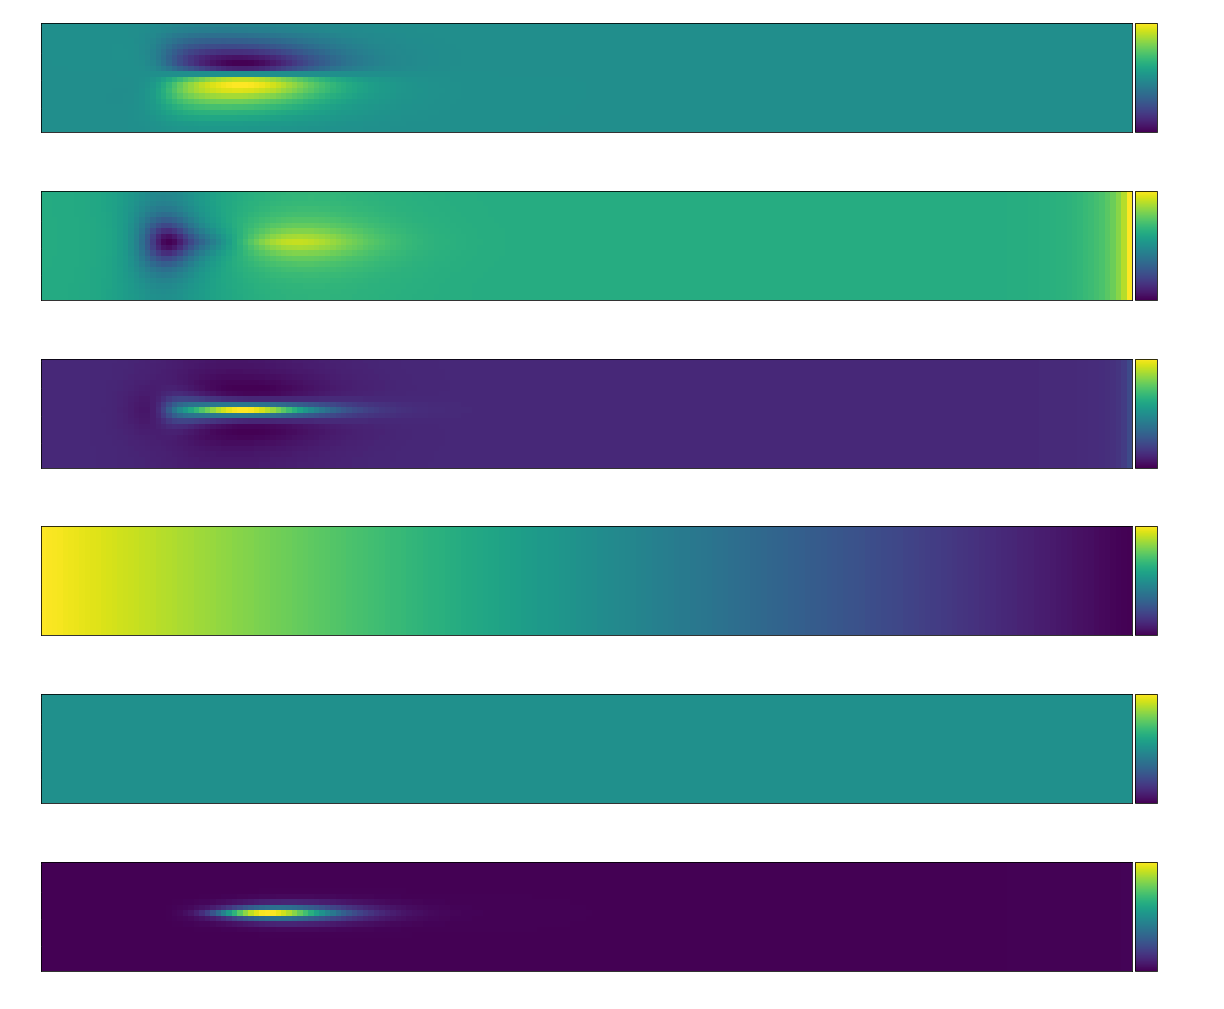

In [123]:
plot_sample(data,2,view="top")

**WEIRD DATA RIGHT BOUNDARY**

<Figure size 1440x1080 with 0 Axes>

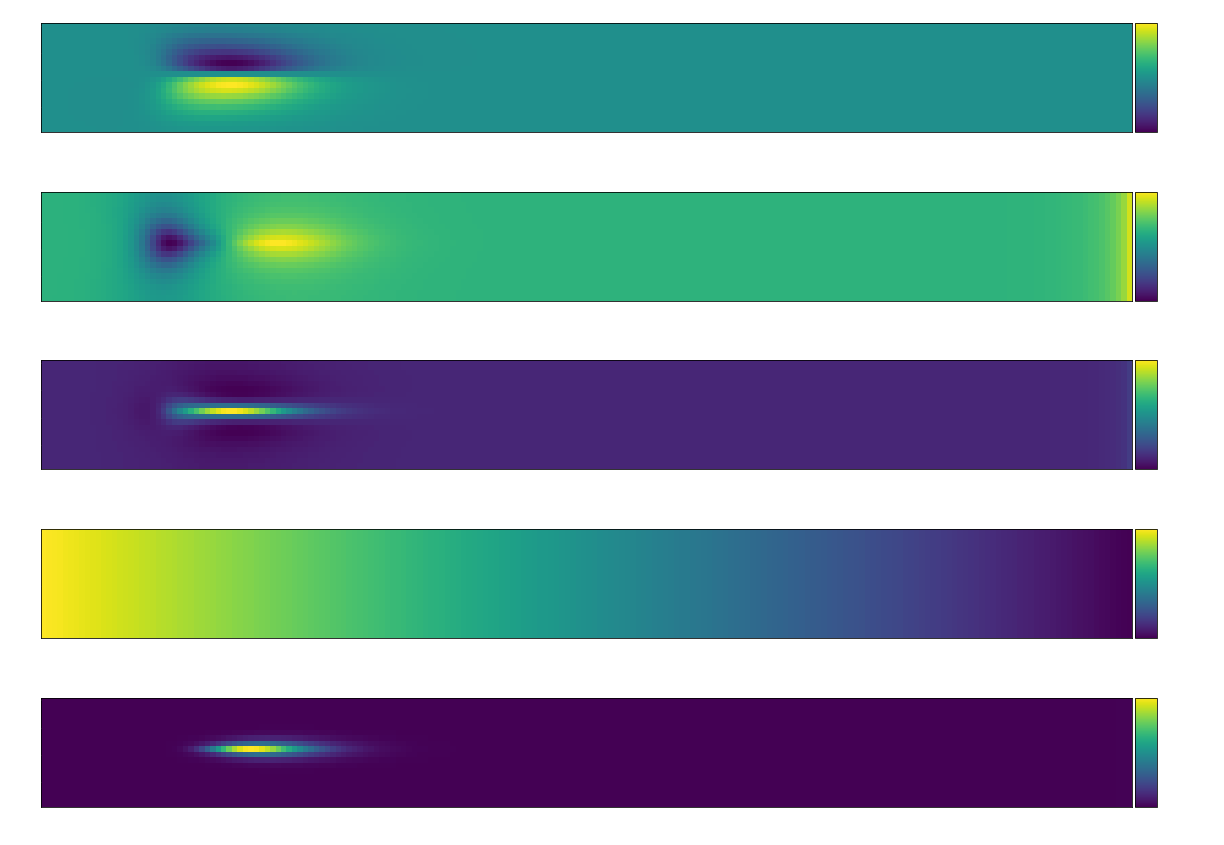

In [52]:
plot_sample(data,6,view="top")

<Figure size 1440x1080 with 0 Axes>

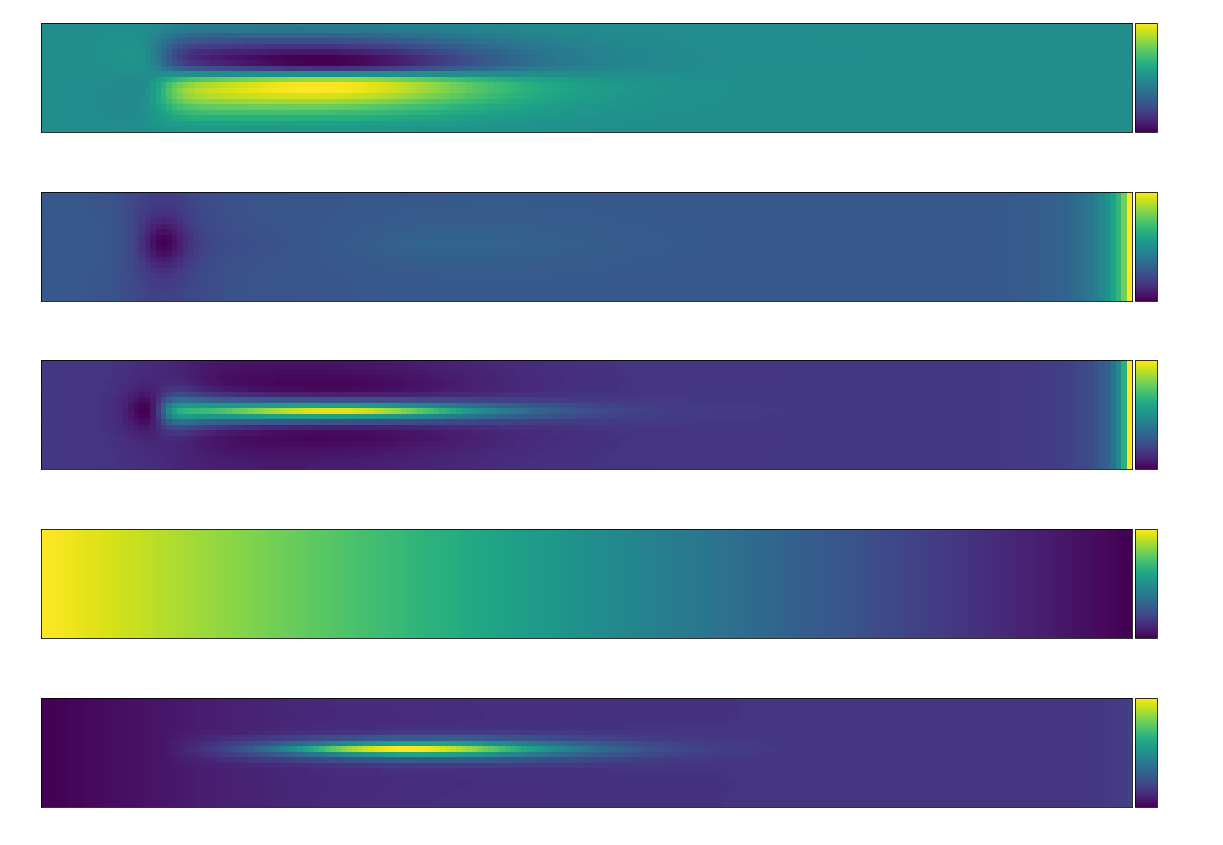

In [54]:
plot_sample(data,1,view="top")

<Figure size 1440x1080 with 0 Axes>

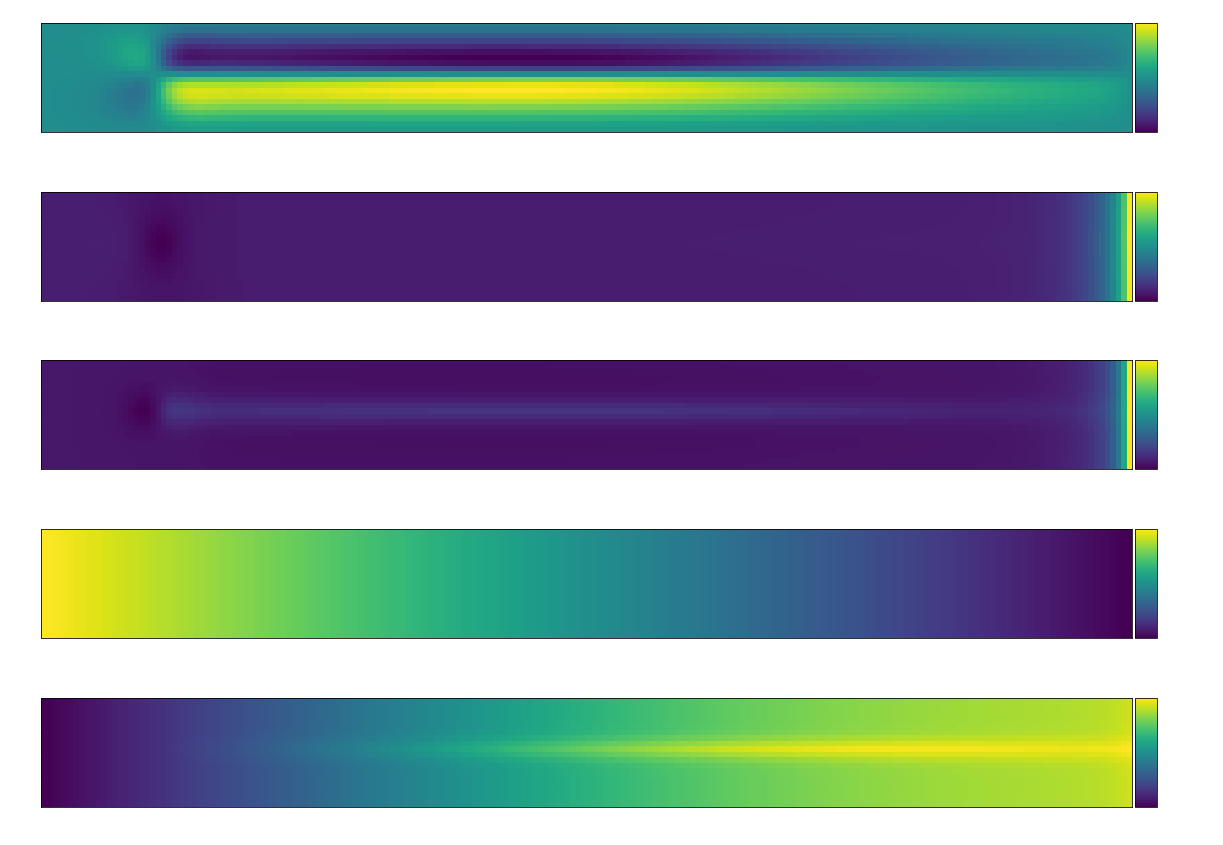

In [50]:
plot_sample(data,8,view="top")

<Figure size 1440x1080 with 0 Axes>

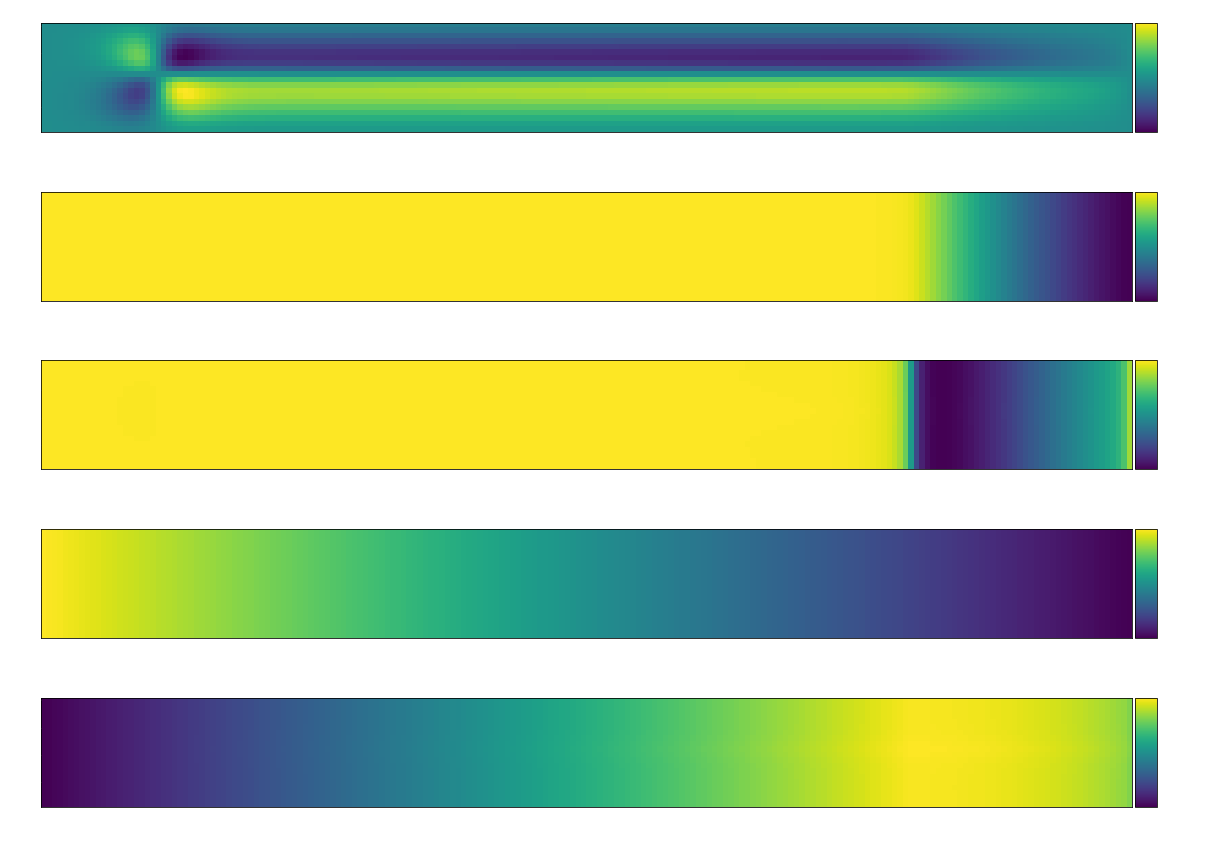

In [49]:
plot_sample(data,3,view="top")

#TODO prep data? normalize all input values (vel/pressure) and all output values (temp/vel?) ?

**Preprocessing**

wrong input data -> later: change to pressure/ velocity of step 0

In [ ]:
# parameter setting
train_size_percent = 0.75
test_size_percent = 0.25

np.random.seed(seed=1) # just for programming and varification purposes at this point, delete later!

def split_dataset(train_size_percent, test_size_percent, dataset_pressure, dataset_temperature, dataset_vel_x, dataset_vel_y, dataset_vel_z):
    # calculating parameters from settings
    dataset_size = len(dataset_pressure)
    train_size = int(dataset_size * train_size_percent)
    test_size = int(dataset_size * test_size_percent)

    # create random split of data
    indices = np.arange(0,100)
    np.random.shuffle(indices)
    indices_train = indices[:train_size]
    indices_test = indices[train_size:train_size+test_size]

    # split dataset into training and validation data 
    data_train_pressure = []
    data_train_temperature = []
    data_train_vel_x = []
    data_train_vel_y = []
    data_train_vel_z = []

    data_test_pressure = []
    data_test_temperature = []
    data_test_vel_x = []
    data_test_vel_y = []
    data_test_vel_z = []

    for index in indices_train:
        data_train_pressure.append(dataset_pressure[index])
        data_train_temperature.append(dataset_temperature[index])
        data_train_vel_x.append(dataset_vel_x[index])
        data_train_vel_y.append(dataset_vel_y[index])
        data_train_vel_z.append(dataset_vel_z[index])

    for index in indices_test:
        data_test_pressure.append(dataset_pressure[index])
        data_test_temperature.append(dataset_temperature[index])
        data_test_vel_x.append(dataset_vel_x[index])
        data_test_vel_y.append(dataset_vel_y[index])
        data_test_vel_z.append(dataset_vel_z[index])

    data_train_pressure = np.array(data_train_pressure)
    data_train_temperature = np.array(data_train_temperature)
    data_train_vel_x = np.array(data_train_vel_x)
    data_train_vel_y = np.array(data_train_vel_y)
    data_train_vel_z = np.array(data_train_vel_z)
    data_test_pressure = np.array(data_test_pressure)
    data_test_temperature = np.array(data_test_temperature)
    data_test_vel_x = np.array(data_test_vel_x)
    data_test_vel_y = np.array(data_test_vel_y)
    data_test_vel_z = np.array(data_test_vel_z)

    return data_train_pressure, data_train_temperature, data_train_vel_x, data_train_vel_y, data_train_vel_z, data_test_pressure, data_test_temperature, data_test_vel_x, data_test_vel_y, data_test_vel_z

#TODO prep data? normalize all input values (vel/pressure) and all output values (temp/vel?) ?

In [ ]:
data_train_pressure, data_train_temperature, data_train_vel_x, data_train_vel_y, data_train_vel_z, data_test_pressure, data_test_temperature, data_test_vel_x, data_test_vel_y, data_test_vel_z = split_dataset(train_size_percent, test_size_percent, dataset_pressure_init, dataset_temperature, dataset_vel_x, dataset_vel_y, dataset_vel_z)

IndexError: list index out of range

**FCN model definition**

adapted from https://github.com/himanshurawlani/fully_convolutional_network.git
made it 3D

In [48]:
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Dropout, BatchNormalization, Activation
from tensorflow.keras.utils import to_categorical

In [68]:
kernel = 3#(3, 3, 3, 1)
def FCN_model(input_shape=(20,200,16,1), len_classes=5, dropout_rate=0.2, kernel=3):

    input = Input(shape=input_shape) #2D: (None, None, 3))
    x = Conv3D(filters=32, kernel_size=kernel, strides=1,padding="same")(input) 
    #  filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # x = tf.keras.layers.MaxPooling2D()(x)

    x = Conv3D(filters=64, kernel_size=kernel, strides=1,padding= "same")(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # x = tf.keras.layers.MaxPooling2D()(x)

    x = Conv3D(filters=128, kernel_size=kernel, strides=2)(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # x = tf.keras.layers.MaxPooling2D()(x)

    x = Conv3D(filters=256, kernel_size=kernel, strides=2)(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # x = tf.keras.layers.MaxPooling2D()(x)

    # x = Conv3D(filters=512, kernel_size=kernel, strides=2)(x)
    # x = Dropout(dropout_rate)(x)
    # x = BatchNormalization()(x)
    # x = Activation('relu')(x)

    # Uncomment the below line if you're using dense layers
    # x = tf.keras.layers.GlobalMaxPooling2D()(x)

    # Fully connected layer 1
    # x = tf.keras.layers.Dropout(dropout_rate)(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Dense(units=64)(x)
    # x = tf.keras.layers.Activation('relu')(x)

    # Fully connected layer 1
    x = Conv3D(filters=64, kernel_size=1, strides=1)(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Fully connected layer 2
    # x = tf.keras.layers.Dropout(dropout_rate)(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Dense(units=len_classes)(x)
    # predictions = tf.keras.layers.Activation('softmax')(x)

    # Fully connected layer 2
    x = Conv3D(filters=len_classes, kernel_size=1, strides=1)(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x)
    #x = GlobalMaxPooling3D()(x) #TODO I PERSONALLY EXCLUDED - BACK IN?
    predictions = Activation('softmax')(x)

    model = tensorflow.keras.Model(inputs=input, outputs=predictions)
    
    print(model.summary())
    print(f'Total number of layers: {len(model.layers)}')

    return model


In [69]:
model = FCN_model(input_shape=(20, 200, 16, 1), len_classes=5, dropout_rate=0.2)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 20, 200, 16, 1)]  0         
                                                                 
 conv3d_37 (Conv3D)          (None, 20, 200, 16, 32)   896       
                                                                 
 dropout_28 (Dropout)        (None, 20, 200, 16, 32)   0         
                                                                 
 batch_normalization_28 (Bat  (None, 20, 200, 16, 32)  128       
 chNormalization)                                                
                                                                 
 activation_28 (Activation)  (None, 20, 200, 16, 32)   0         
                                                                 
 conv3d_38 (Conv3D)          (None, 20, 200, 16, 64)   55360     
                                                             